In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "C://Users//marco//Downloads//IMC-Prosperity-2025-Rice//72ef7f15-aea6-4d03-9af9-6c05c710c932.csv"
df = pd.read_csv(file_path, delimiter=';')

In [30]:
df.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,31,NaN,NaN,NaN,NaN,2028.5,0.0
2,-1,100,KELP,2025,24,NaN,NaN,NaN,NaN,2028,2,2029.0,22.0,NaN,NaN,2026.5,0.0
3,-1,100,RAINFOREST_RESIN,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,0.0
4,-1,200,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,0.0


In [32]:
def weighted_midprice(df, levels=1, quantity_power = 1):
    def calculate_weighted_midprice(row, levels, quantity_power):
        bid_side = []
        ask_side = []
        
        for level in range(1, levels + 1):
            bid_price = row.get(f'bid_price_{level}', np.nan)
            bid_volume = row.get(f'bid_volume_{level}', np.nan) ** quantity_power
            ask_price = row.get(f'ask_price_{level}', np.nan)
            ask_volume = row.get(f'ask_volume_{level}', np.nan) ** quantity_power
            
            if np.isfinite(bid_price) and np.isfinite(bid_volume) and bid_volume > 0:
                bid_side.append((bid_price, bid_volume))
            if np.isfinite(ask_price) and np.isfinite(ask_volume) and ask_volume > 0:
                ask_side.append((ask_price, ask_volume))
        
        if not bid_side or not ask_side:
            return np.nan
        
        total_bid_weight = sum(volume for _, volume in bid_side)
        total_ask_weight = sum(volume for _, volume in ask_side)
        
        weighted_bid_price = sum(price * volume for price, volume in bid_side) / total_bid_weight if total_bid_weight > 0 else np.nan
        weighted_ask_price = sum(price * volume for price, volume in ask_side) / total_ask_weight if total_ask_weight > 0 else np.nan
        
        return (weighted_bid_price + weighted_ask_price) / 2 if np.isfinite(weighted_bid_price) and np.isfinite(weighted_ask_price) else np.nan
    
    return df.apply(lambda row: calculate_weighted_midprice(row, levels, quantity_power), axis=1)

df['weighted_midprice_level_1'] = weighted_midprice(df, levels=1, quantity_power = 1)
df['weighted_midprice_level_2'] = weighted_midprice(df, levels=2, quantity_power = 1)
df['weighted_midprice_level_3'] = weighted_midprice(df, levels=3, quantity_power = 1)

df['log_return_l1'] = df.groupby('product')['weighted_midprice_level_1'].transform(lambda x: np.log(x / x.shift()).fillna(0))
df['log_return_l2'] = df.groupby('product')['weighted_midprice_level_2'].transform(lambda x: np.log(x / x.shift()).fillna(0))
df['log_return_l3'] = df.groupby('product')['weighted_midprice_level_3'].transform(lambda x: np.log(x / x.shift()).fillna(0))

lags_realized_vol = [5, 10, 20]

for lag in lags_realized_vol:
    df[f'realized_vol_lag_{lag}'] = df.groupby('product')['log_return_l1'].transform(lambda x: x.pow(2).rolling(window=lag, min_periods=lag).mean().pow(0.5))

display(df.head())


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,profit_and_loss,weighted_midprice_level_1,weighted_midprice_level_2,weighted_midprice_level_3,log_return_l1,log_return_l2,log_return_l3,realized_vol_lag_5,realized_vol_lag_10,realized_vol_lag_20
0,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,...,0.0,10003.0,10001.467742,10000.108367,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,...,0.0,2028.5,2027.833333,2027.078125,0.000000,0.000000,0.000000,NaN,NaN,NaN
2,-1,100,KELP,2025,24,NaN,NaN,NaN,NaN,2028,...,0.0,2026.5,2026.958333,2026.958333,-0.000986,-0.000432,-0.000059,NaN,NaN,NaN
3,-1,100,RAINFOREST_RESIN,9996,2,9995.0,22.0,NaN,NaN,10004,...,0.0,10000.0,10000.000000,10000.000000,-0.000300,-0.000147,-0.000011,NaN,NaN,NaN
4,-1,200,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,...,0.0,10000.0,10000.000000,10000.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.371
Model:                            OLS   Adj. R-squared (uncentered):              0.371
Method:                 Least Squares   F-statistic:                              392.4
Date:                Sat, 08 Mar 2025   Prob (F-statistic):                   3.06e-200
Time:                        14:08:17   Log-Likelihood:                          14523.
No. Observations:                1995   AIC:                                 -2.904e+04
Df Residuals:                    1992   BIC:                                 -2.902e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

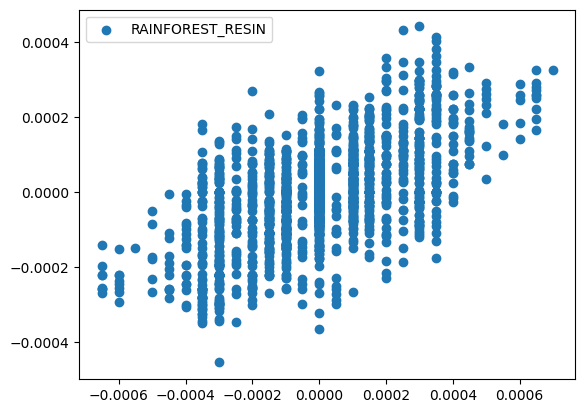

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.261
Model:                            OLS   Adj. R-squared (uncentered):              0.260
Method:                 Least Squares   F-statistic:                              234.9
Date:                Sat, 08 Mar 2025   Prob (F-statistic):                   1.83e-130
Time:                        14:08:18   Log-Likelihood:                          13153.
No. Observations:                1995   AIC:                                 -2.630e+04
Df Residuals:                    1992   BIC:                                 -2.628e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

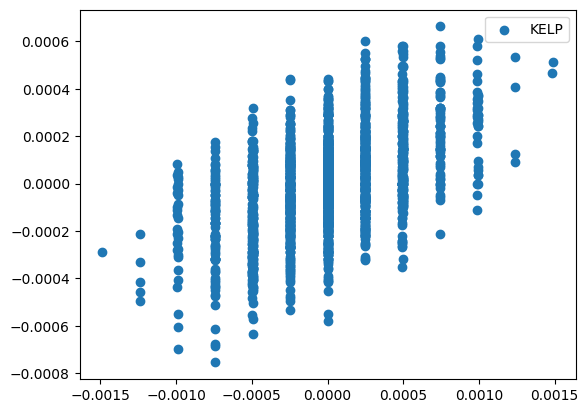

{'RAINFOREST_RESIN': array([-0.73541417, -0.50879543, -0.75997904]), 'KELP': array([-0.58603507, -0.30877435, -0.34055787])}
{'RAINFOREST_RESIN': 0.6094643900796543, 'KELP': 0.511164616326368}


In [35]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


def har_all_features(X, lags, window_y=1):
    df = pd.DataFrame(X.T)
    
    # Calculate lag features (unchanged from your original code)
    lag_features = np.zeros((df.shape[0], len(lags) * df.shape[1]))
    for i, lag in enumerate(lags):
        start_ind = i * df.shape[1]
        end_ind = (i + 1) * df.shape[1]
        if i == 0:
            lag_features[:, start_ind : end_ind] = df.rolling(lag).mean().shift(1).to_numpy()
        else:
            prev_lag = lags[i-1]  # Previous lag boundary
            lag_features[:, start_ind:end_ind] = (
                df.rolling(lag).sum().shift(1).to_numpy() - df.rolling(prev_lag).sum().shift(1).to_numpy()
            ) / (lag - prev_lag)
    
    # For features_y, calculate forward-looking averages
    features_y = np.zeros_like(df.values)
    for i in range(len(df) - window_y + 1):
        # For each eligible row, compute average of current and next window_y-1 values
        features_y[i] = df.iloc[i:i+window_y].mean().values
    
    # Set valid range accounting for both lags and forward window
    start_idx = max(lags)
    end_idx = len(df) - window_y + 1
    
    # Return only the valid range
    return lag_features[start_idx:end_idx], features_y[start_idx:end_idx]


betas = {}

signal_return_correlation = {}
for product in df['product'].unique():

    X, y = har_all_features(df[df['product'] == product]['log_return_l1'], lags=[1, 2, 5], window_y=1)

    model = sm.OLS(y, X).fit()

    print(model.summary())
    y_pred = model.predict(X)

    plt.scatter(y, y_pred, label = product)
    plt.legend()
    plt.show()
    betas[product] = model.params
    signal_return_correlation[product] = model.rsquared ** 0.5

print(betas)
print(signal_return_correlation)


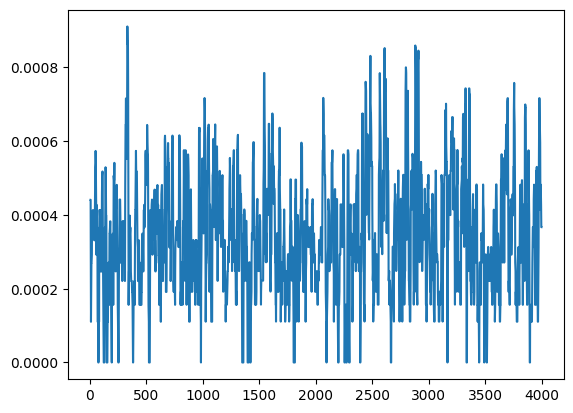

# Calculate historical vol
- Add theo columnm which is the true mid price using weighted average using tightest spread and quantity fraction
- Add rolling average of mid prices (window_size=5)
- Add a vol column where we calculate vol based on last 5 entries

In [ ]:
import re
import pandas as pd

def parse_log_to_df(log_file: str):
    """
    Parses a trading log file and extracts timestamp, symbol, fill percentage,
    expected return, and realized return.
    """
    data = []
    with open(log_file, 'r') as file:
        for line in file:
            # Match fill percentage log
            fill_match = re.search(r"\[(\d+)\]\[(\w+)\] Fill %: ([\d.]+)%", line)
            
            # Match expected return log
            expected_match = re.search(r"Expected Return at timestamp (\d+): ({.*?})", line)
            
            # Match realized return log
            realized_match = re.search(r"Realized Return at timestamp (\d+): ({.*?})", line)

            # Extract Fill %
            if fill_match:
                timestamp, symbol, fill_pct = fill_match.groups()
                data.append({
                    "Timestamp": int(timestamp),
                    "Symbol": symbol,
                    "Fill Percentage": float(fill_pct),
                    "Expected Return": None,
                    "Realized Return": None
                })
            
            # Extract Expected Returns
            elif expected_match:
                timestamp, expected_dict = expected_match.groups()
                expected_dict = eval(expected_dict)  # Convert string dict to real dict
                
                for symbol, exp_ret in expected_dict.items():
                    data.append({
                        "Timestamp": int(timestamp),
                        "Symbol": symbol,
                        "Fill Percentage": None,
                        "Expected Return": float(exp_ret),
                        "Realized Return": None
                    })
            
            # Extract Realized Returns
            elif realized_match:
                timestamp, realized_dict = realized_match.groups()
                realized_dict = eval(realized_dict)  # Convert string dict to real dict
                
                for symbol, real_ret in realized_dict.items():
                    data.append({
                        "Timestamp": int(timestamp),
                        "Symbol": symbol,
                        "Fill Percentage": None,
                        "Expected Return": None,
                        "Realized Return": float(real_ret)
                    })

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Forward fill missing values for matching timestamps
    df.sort_values(["Timestamp", "Symbol"], inplace=True)
    df.fillna(method='ffill', inplace=True)

    return df

# Example usage:
log_df = parse_log_to_df("trading_log.log")




summary_fill_statistics = log_df.groupby('Symbol').agg({'Fill Percentage': 'mean'})

display(summary_fill_statistics)

for symbol in log_df['Symbol'].unique():
    plt.scatter(log_df[log_df['Symbol'] == symbol]['Expected Return'], log_df[log_df['Symbol'] == symbol]['Realized Return'], label = symbol)
    plt.legend()
    plt.show()



### Summary of PNL Per Product / Strategy

### Multiple Theos - Effect of Bid-Ask Bounce

### Execution Probability of Maker Orders Given Width

### Volatility Regression

### Forecasting Future Price Given Fills And Past Returns

### Lead / Lag Relationships

### Cross-Product Correlations